# Air Quality per City (Udaipur / Amritsar / Faridabad)

Runs the full pipeline **separately** for each city using Open‑Meteo Air Quality API.
Per city: EDA → PCA → Random Forest (daily PM2.5) → Clustering with Jaccard evaluation.


In [1]:
!pip -q install pandas numpy requests tqdm scikit-learn seaborn matplotlib scikit-learn-extra
import pandas as pd, numpy as np, requests, math
from datetime import datetime, timedelta
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.cluster import KMeans, AgglomerativeClustering
try:
    from sklearn_extra.cluster import KMedoids
    HAS_EXTRA = True
except Exception:
    HAS_EXTRA = False
pd.set_option('display.max_columns', 200)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 15.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.12/dist-package

## Utilities: geocoding, fetching, clustering helpers

In [2]:
GEOCODE_URL = "https://geocoding-api.open-meteo.com/v1/search"
AQ_URL = "https://air-quality-api.open-meteo.com/v1/air-quality"
HOURLY = [
  "pm2_5","pm10","ozone","nitrogen_dioxide","sulphur_dioxide","carbon_monoxide",
  "dust","aerosol_optical_depth","methane",
  "us_aqi","us_aqi_pm2_5","us_aqi_pm10","us_aqi_ozone","us_aqi_nitrogen_dioxide","us_aqi_sulphur_dioxide","us_aqi_carbon_monoxide"
]

def geocode_city(name: str):
    params = {"name": name, "count": 1, "language": "en", "format": "json"}
    r = requests.get(GEOCODE_URL, params=params, timeout=30)
    r.raise_for_status()
    j = r.json()
    if j.get('results'):
        res = j['results'][0]
        return {'name': res.get('name', name), 'latitude': res['latitude'], 'longitude': res['longitude'], 'timezone': res.get('timezone','auto')}
    raise ValueError(f"No geocoding result for {name}")

def fetch_hourly_for_city(city_name, start_date="2022-08-01", end_date=None):
    c = geocode_city(city_name)
    if end_date is None:
        end_date = datetime.utcnow().date().isoformat()
    start = datetime.fromisoformat(start_date)
    end = datetime.fromisoformat(end_date)
    frames = []
    cur = start
    with tqdm(total=(end-start).days, desc=f"Fetching {city_name}") as pbar:
        while cur <= end:
            win_end = min(cur + timedelta(days=30), end)
            params = {
                "latitude": c['latitude'],
                "longitude": c['longitude'],
                "hourly": ",".join(HOURLY),
                "timezone": c['timezone'],
                "start_date": cur.date().isoformat(),
                "end_date": win_end.date().isoformat(),
                "domains": "cams_global",
            }
            try:
                r = requests.get(AQ_URL, params=params, timeout=60)
                r.raise_for_status()
                j = r.json()
                if 'hourly' in j and 'time' in j['hourly']:
                    df = pd.DataFrame(j['hourly'])
                    df['city'] = city_name
                    frames.append(df)
            except Exception as ex:
                print("Chunk failed:", ex)
            pbar.update((win_end - cur).days)
            cur = win_end + timedelta(days=1)
    out = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()
    if not out.empty:
        out['time'] = pd.to_datetime(out['time'])
        out = out.sort_values('time').reset_index(drop=True)
    return out

def jaccard_similarity(a, b):
    inter = np.logical_and(a, b).sum()
    union = np.logical_or(a, b).sum()
    return inter / max(1, union)

def cluster_jaccard_stats(B, labels):
    from itertools import combinations
    B = B.astype(bool)
    clusters = np.unique(labels)
    intra, inter = [], []
    for k in clusters:
        idx = np.where(labels==k)[0]
        if len(idx) > 1:
            pairs = list(combinations(idx, 2))
            intra += [jaccard_similarity(B[i], B[j]) for i,j in pairs]
    for k1 in clusters:
        for k2 in clusters:
            if k1 >= k2: continue
            i1 = np.where(labels==k1)[0]
            i2 = np.where(labels==k2)[0]
            for i in i1:
                for j in i2:
                    inter.append(jaccard_similarity(B[i], B[j]))
    return (np.mean(intra) if intra else np.nan, np.mean(inter) if inter else np.nan)

def jaccard_distance_matrix(B):
    n = B.shape[0]
    D = np.zeros((n,n), dtype=float)
    for i in range(n):
        for j in range(i+1, n):
            s = jaccard_similarity(B[i], B[j])
            D[i,j] = D[j,i] = 1.0 - s
    return D

## Cities to process

In [3]:
cities = ["Udaipur","amritsar","faridabad","muzaffarnagar"]
cities

['Udaipur', 'amritsar', 'faridabad', 'muzaffarnagar']

## Pipeline per city (no cross-city merging)


Processing: Udaipur


/tmp/ipython-input-1320487617.py:22: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end_date = datetime.utcnow().date().isoformat()
Fetching Udaipur:  97%|█████████▋| 1162/1200 [00:29<00:00, 39.91it/s]
/tmp/ipython-input-1320487617.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  out = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()


Hourly rows: 28824 | Range: 2022-08-01 00:00:00 -> 2025-11-13 23:00:00


,0
methane,0.680440
us_aqi_pm10,0.003504
us_aqi,0.003504
us_aqi_pm2_5,0.003504
us_aqi_carbon_monoxide,0.002949
us_aqi_ozone,0.002949
pm2_5,0.002671
pm10,0.002671
aerosol_optical_depth,0.002671
dust,0.002671


,count,mean,std,min,25%,50%,75%,max
pm2_5,28747.0,21.629,13.362,0.20,12.70,18.30,27.10,129.90
pm10,28747.0,37.111,22.128,0.20,22.10,32.80,47.50,356.70
ozone,28747.0,83.505,30.952,5.00,60.00,78.00,105.00,178.00
nitrogen_dioxide,28747.0,6.907,6.770,0.00,2.10,5.20,9.30,56.90
sulphur_dioxide,28747.0,6.221,4.336,0.20,3.20,5.00,7.90,35.40
carbon_monoxide,28747.0,239.753,103.786,58.00,160.00,213.00,298.00,876.00
dust,28747.0,20.400,32.833,0.00,2.00,8.00,25.00,558.00
aerosol_optical_depth,28747.0,0.332,0.199,0.02,0.19,0.29,0.43,2.17
methane,9211.0,1419.208,57.956,1314.00,1373.00,1404.00,1457.00,1685.00
us_aqi,28723.0,72.533,26.956,14.00,55.00,66.00,86.00,179.00


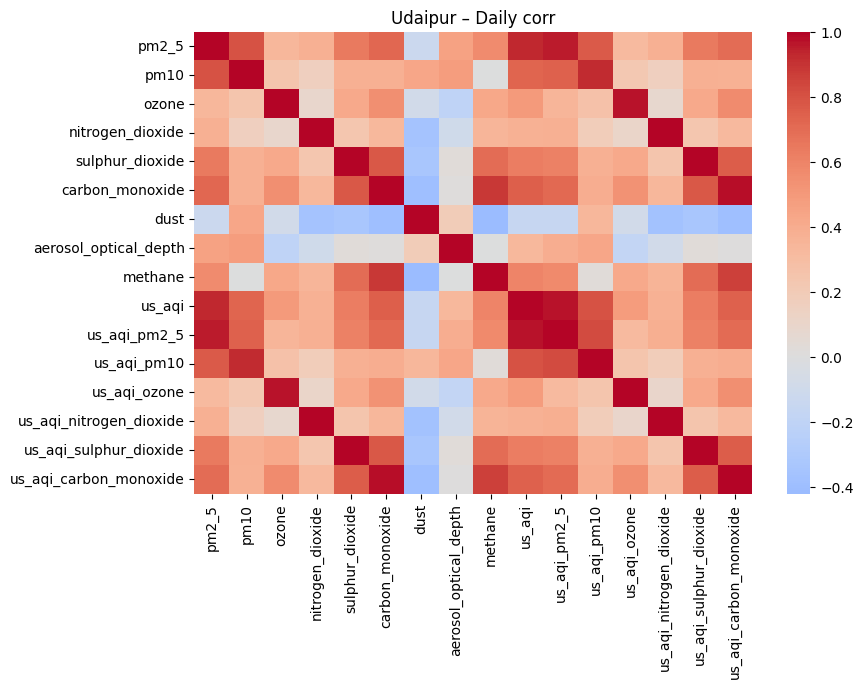

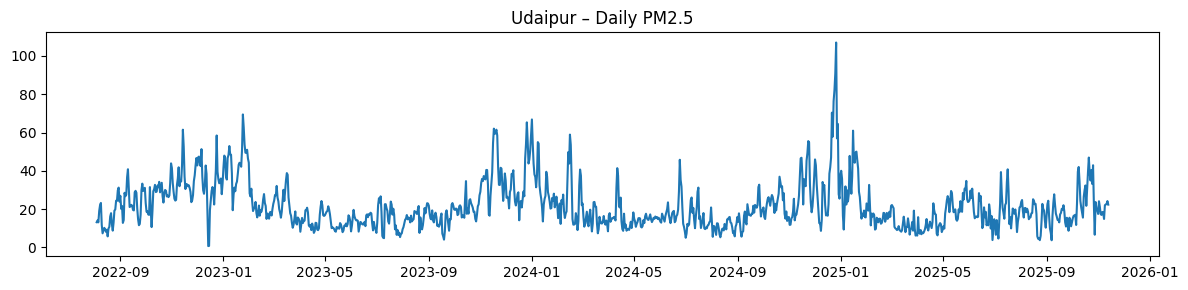

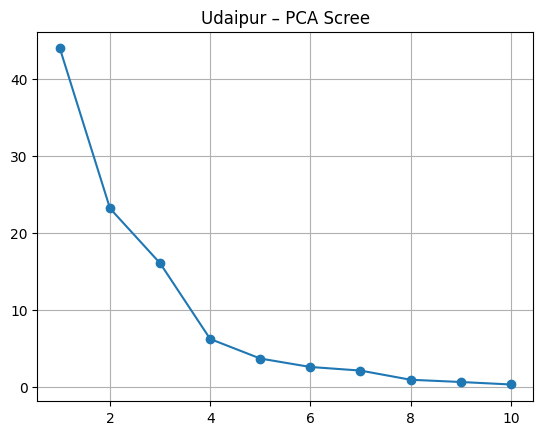

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
carbon_monoxide,0.342962,-0.155058,0.011040,0.024704,-0.077721,0.321141,0.068681,-0.361136,-0.230696,-0.044829
us_aqi_carbon_monoxide,0.340380,-0.153169,0.024694,0.014229,-0.104905,0.325360,0.031440,-0.397112,-0.381565,0.114109
us_aqi,0.328375,0.194698,-0.006588,0.029490,-0.225745,-0.130951,-0.346083,0.136674,0.043609,0.561779
sulphur_dioxide,0.321423,-0.113491,0.058009,0.097307,0.572318,-0.177155,0.017626,0.086028,-0.036502,0.014959
us_aqi_sulphur_dioxide,0.321069,-0.112631,0.057551,0.096638,0.576188,-0.176838,0.021973,0.084153,-0.038990,0.024475
methane,0.316206,-0.131383,-0.012743,0.071617,-0.163553,0.454434,0.437937,0.619086,0.243890,-0.032784
us_aqi_pm2_5,0.312408,0.228702,-0.115233,0.096199,-0.134406,0.024113,-0.380009,0.138633,0.033173,0.133959
pm2_5,0.309482,0.240438,-0.097792,0.177447,-0.065569,-0.056293,-0.034075,-0.296381,0.561354,-0.347843
us_aqi_ozone,0.195956,-0.090502,0.449652,-0.265036,-0.232658,-0.388458,0.144918,0.033893,0.019088,0.159034
ozone,0.193578,-0.072063,0.483699,-0.206799,-0.228362,-0.242348,0.100529,-0.030086,-0.003392,-0.324146


Udaipur – RF mean metrics: MAE=3.95, RMSE=6.02, R2=0.365


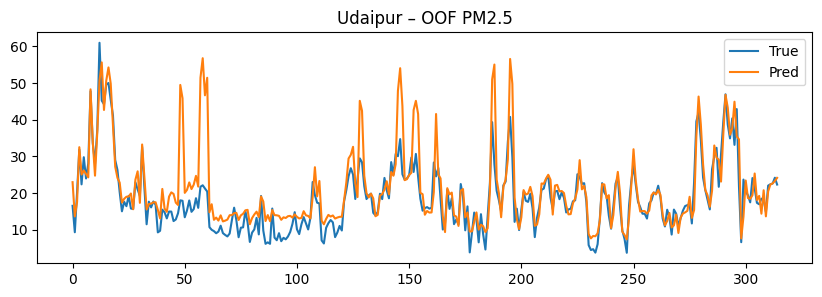

Udaipur – KMeans Jaccard: intra=0.107, inter=0.018
Udaipur – Agglomerative(Jaccard): intra=0.116, inter=0.000


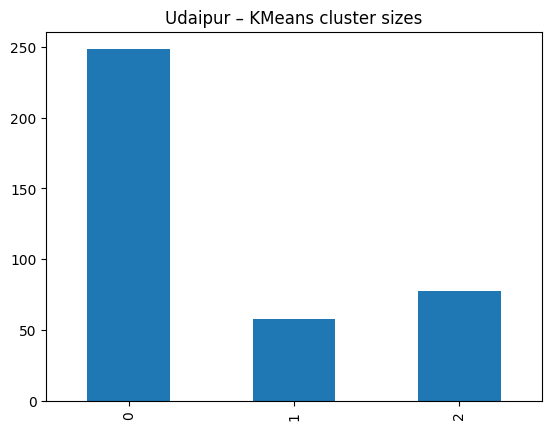

Saved udaipur_daily_air_quality.csv

Processing: amritsar


/tmp/ipython-input-1320487617.py:22: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end_date = datetime.utcnow().date().isoformat()
Fetching amritsar:  97%|█████████▋| 1162/1200 [00:30<00:00, 38.34it/s]
/tmp/ipython-input-1320487617.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  out = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()


Hourly rows: 28824 | Range: 2022-08-01 00:00:00 -> 2025-11-13 23:00:00


,0
methane,0.680440
us_aqi_pm10,0.003504
us_aqi,0.003504
us_aqi_pm2_5,0.003504
us_aqi_carbon_monoxide,0.002949
us_aqi_ozone,0.002949
us_aqi_nitrogen_dioxide,0.002741
pm2_5,0.002671
aerosol_optical_depth,0.002671
dust,0.002671


,count,mean,std,min,25%,50%,75%,max
pm2_5,28747.0,62.647,43.649,0.50,33.40,49.60,76.60,352.00
pm10,28747.0,95.264,67.278,0.70,51.60,76.40,118.30,873.60
ozone,28747.0,92.339,53.606,-3.00,49.00,82.00,134.00,300.00
nitrogen_dioxide,28747.0,21.852,23.543,-0.20,5.60,13.10,29.30,172.10
sulphur_dioxide,28747.0,12.750,8.275,0.00,7.10,10.60,16.00,76.40
carbon_monoxide,28747.0,764.654,659.928,59.00,349.00,539.00,918.00,7151.00
dust,28747.0,33.034,84.184,0.00,2.00,8.00,25.00,1444.00
aerosol_optical_depth,28747.0,0.592,0.352,0.03,0.34,0.52,0.76,3.73
methane,9211.0,1685.044,201.459,1381.00,1535.00,1636.00,1787.00,2722.00
us_aqi,28723.0,139.056,41.328,12.00,108.00,142.00,162.00,579.00


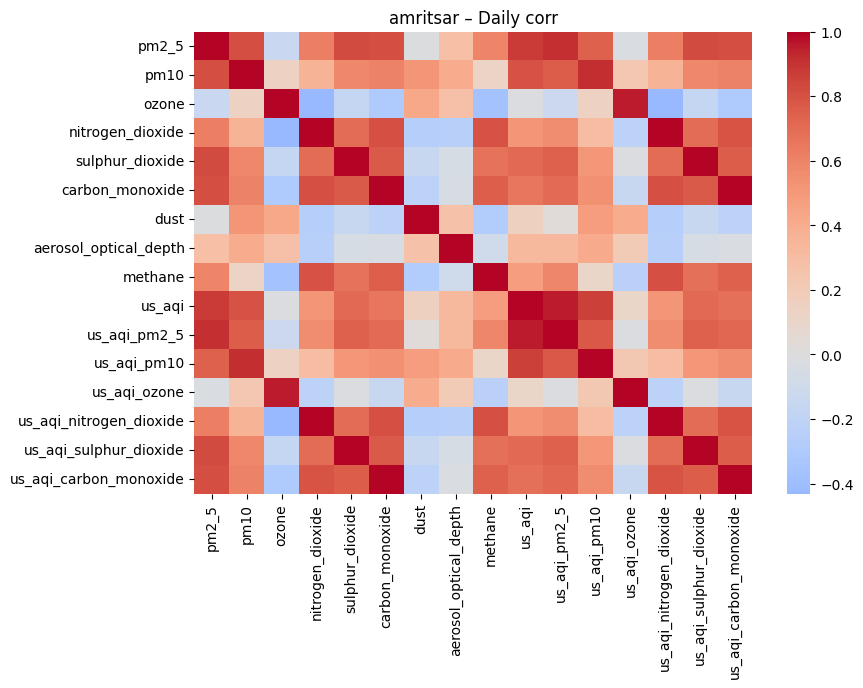

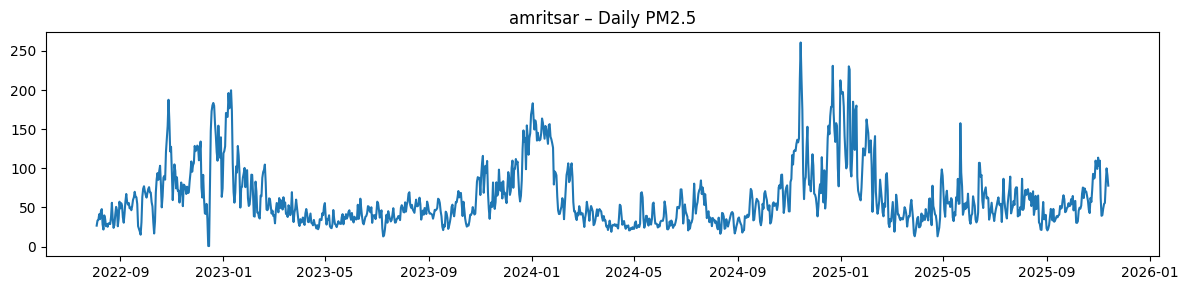

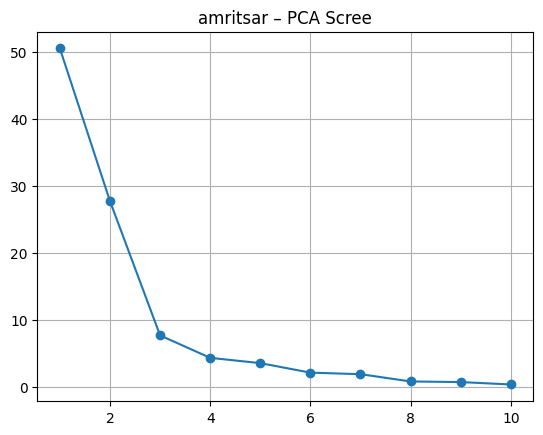

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
us_aqi_sulphur_dioxide,0.328489,-0.008361,0.140317,-0.156105,-0.247034,-0.153994,-0.264992,0.233157,0.363615,-0.048509
sulphur_dioxide,0.328347,-0.008065,0.140583,-0.155154,-0.248951,-0.153336,-0.264951,0.236170,0.366718,-0.044289
carbon_monoxide,0.327188,-0.048568,0.058356,-0.236191,-0.199014,-0.071842,0.341996,0.051522,-0.361896,-0.115999
us_aqi_carbon_monoxide,0.326161,-0.040284,0.034465,-0.252117,-0.193054,-0.032037,0.385813,0.013144,-0.335072,-0.218694
pm2_5,0.316328,0.144243,-0.151103,-0.131781,-0.028346,-0.122096,-0.155064,-0.406387,-0.072033,0.634767
us_aqi_pm2_5,0.298410,0.164187,-0.206911,-0.077270,0.153458,0.322729,-0.096308,-0.483059,0.203463,-0.508532
us_aqi_nitrogen_dioxide,0.283995,-0.184572,0.215775,0.308871,0.267434,-0.078265,-0.267613,0.022182,-0.270452,-0.098672
nitrogen_dioxide,0.283472,-0.185592,0.214938,0.310835,0.268596,-0.076956,-0.266975,0.021752,-0.273444,-0.096403
methane,0.282930,-0.093922,0.148257,0.102163,0.506450,-0.085546,0.591216,0.058403,0.452986,0.220429
us_aqi,0.263811,0.257546,-0.123992,0.089965,0.066019,0.553221,-0.041248,0.064810,0.041371,0.059747


amritsar – RF mean metrics: MAE=8.99, RMSE=13.05, R2=0.412


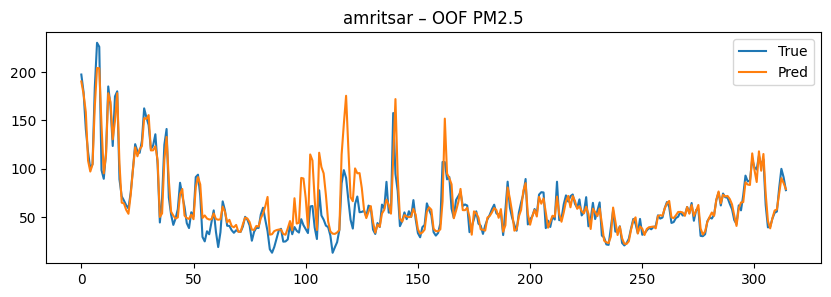

amritsar – KMeans Jaccard: intra=0.777, inter=0.382
amritsar – Agglomerative(Jaccard): intra=0.610, inter=0.000


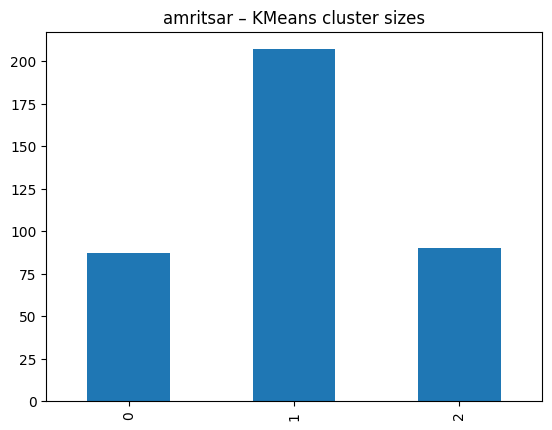

Saved amritsar_daily_air_quality.csv

Processing: faridabad


/tmp/ipython-input-1320487617.py:22: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end_date = datetime.utcnow().date().isoformat()
Fetching faridabad:  97%|█████████▋| 1162/1200 [00:30<00:01, 37.78it/s]
/tmp/ipython-input-1320487617.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  out = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()


Hourly rows: 28824 | Range: 2022-08-01 00:00:00 -> 2025-11-13 23:00:00


,0
methane,0.680440
us_aqi_pm10,0.003504
us_aqi,0.003504
us_aqi_pm2_5,0.003504
us_aqi_ozone,0.003122
us_aqi_carbon_monoxide,0.002949
pm2_5,0.002671
pm10,0.002671
aerosol_optical_depth,0.002671
dust,0.002671


,count,mean,std,min,25%,50%,75%,max
pm2_5,28747.0,78.097,51.811,0.30,41.70,64.30,99.70,443.30
pm10,28747.0,222.733,331.067,0.50,78.90,127.60,210.00,3263.40
ozone,28747.0,80.090,64.299,-11.00,29.00,63.00,128.00,322.00
nitrogen_dioxide,28747.0,48.527,41.123,0.00,17.60,35.80,69.20,336.00
sulphur_dioxide,28747.0,35.392,29.847,0.20,17.50,26.60,42.10,337.60
carbon_monoxide,28747.0,1029.900,1037.106,59.00,421.00,689.00,1248.00,14504.00
dust,28747.0,269.191,615.968,-4.00,8.00,42.00,187.00,5882.00
aerosol_optical_depth,28747.0,0.611,0.336,0.03,0.37,0.54,0.78,4.34
methane,9211.0,1586.451,142.463,1360.00,1489.00,1556.00,1648.00,2632.00
us_aqi,28723.0,222.834,264.643,12.00,129.00,158.00,186.00,2742.00


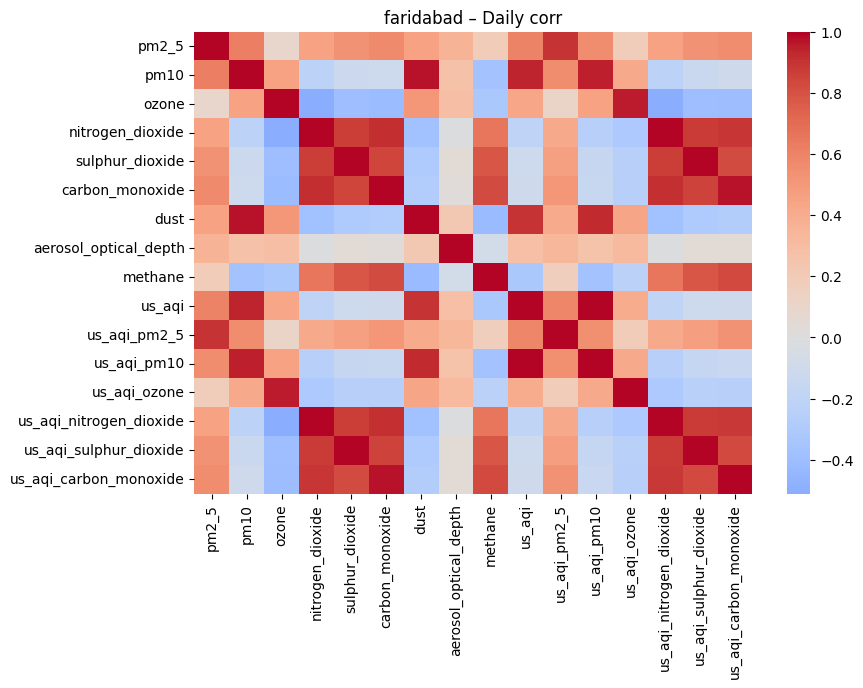

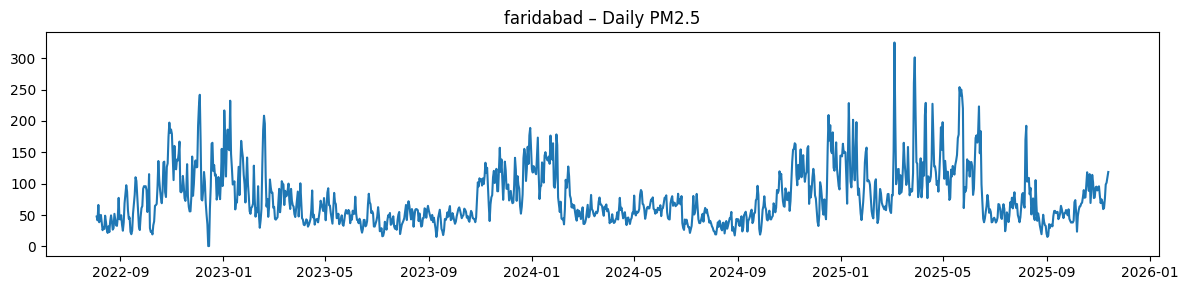

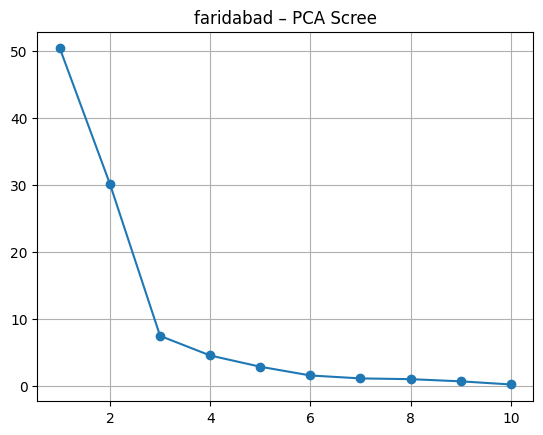

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
nitrogen_dioxide,0.298015,0.177209,-0.058332,0.039877,-0.482401,-0.190271,0.020310,0.253685,0.152670,-0.004409
us_aqi_nitrogen_dioxide,0.296865,0.179026,-0.055620,0.037191,-0.492026,-0.187825,0.012159,0.245820,0.134909,0.014391
carbon_monoxide,0.279829,0.245481,0.047705,-0.062799,0.100705,-0.341883,-0.035664,-0.283784,-0.354730,0.442600
us_aqi_carbon_monoxide,0.274490,0.244324,0.055168,-0.042068,0.178222,-0.430747,-0.042252,-0.392894,-0.174483,-0.482199
us_aqi_sulphur_dioxide,0.273816,0.251583,0.082086,-0.100959,-0.045236,0.530878,-0.060836,-0.019185,-0.192430,-0.126616
sulphur_dioxide,0.273545,0.251762,0.081163,-0.101861,-0.044875,0.532705,-0.064721,-0.018276,-0.199474,-0.123392
methane,0.255627,0.191551,0.179647,-0.088109,0.629196,-0.121756,-0.028277,0.637035,0.198757,0.001543
pm2_5,-0.085297,0.421744,-0.122011,0.099403,0.085035,0.117963,-0.339413,-0.210230,0.334601,0.560996
us_aqi_pm2_5,-0.087260,0.408341,-0.140289,0.087691,0.095028,0.073784,0.594148,-0.251066,0.488524,-0.205160
aerosol_optical_depth,-0.123898,0.157028,0.428642,0.859522,-0.015648,0.009315,-0.038400,0.063227,-0.156514,-0.067427


faridabad – RF mean metrics: MAE=15.28, RMSE=20.27, R2=0.749


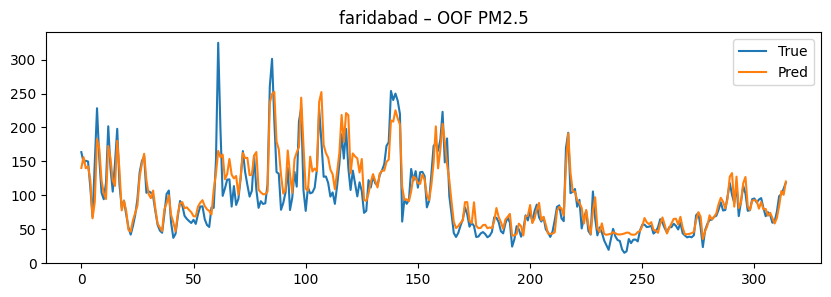

faridabad – KMeans Jaccard: intra=0.877, inter=0.536
faridabad – Agglomerative(Jaccard): intra=0.700, inter=0.000


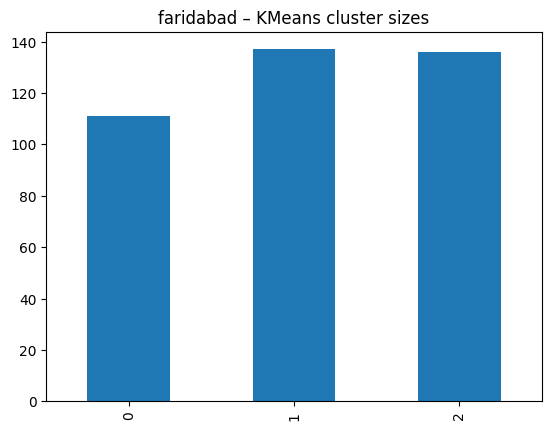

Saved faridabad_daily_air_quality.csv

Processing: muzaffarnagar


/tmp/ipython-input-1320487617.py:22: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end_date = datetime.utcnow().date().isoformat()
Fetching muzaffarnagar:  97%|█████████▋| 1162/1200 [00:30<00:00, 38.32it/s]
/tmp/ipython-input-1320487617.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  out = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()


Hourly rows: 28824 | Range: 2022-08-01 00:00:00 -> 2025-11-13 23:00:00


,0
methane,0.680440
us_aqi_pm10,0.003504
us_aqi,0.003504
us_aqi_pm2_5,0.003504
us_aqi_ozone,0.002984
us_aqi_carbon_monoxide,0.002949
us_aqi_nitrogen_dioxide,0.002741
pm2_5,0.002671
aerosol_optical_depth,0.002671
dust,0.002671


,count,mean,std,min,25%,50%,75%,max
pm2_5,28747.0,55.973,32.568,0.00,32.80,47.40,70.80,265.40
pm10,28747.0,93.609,65.258,0.00,52.00,78.20,117.10,990.90
ozone,28747.0,91.762,47.520,-3.00,55.00,83.00,128.00,256.00
nitrogen_dioxide,28747.0,16.842,15.330,-1.00,6.10,12.60,22.00,115.10
sulphur_dioxide,28747.0,14.374,8.690,0.20,8.50,12.10,18.00,101.70
carbon_monoxide,28747.0,566.618,358.372,59.00,321.00,451.00,698.00,3295.00
dust,28747.0,48.870,106.638,0.00,2.00,9.00,40.00,1590.00
aerosol_optical_depth,28747.0,0.559,0.309,0.03,0.33,0.49,0.71,3.04
methane,9211.0,1615.603,138.784,1392.00,1514.00,1582.00,1688.00,2276.00
us_aqi,28723.0,132.514,36.809,13.00,102.00,137.00,159.00,459.00


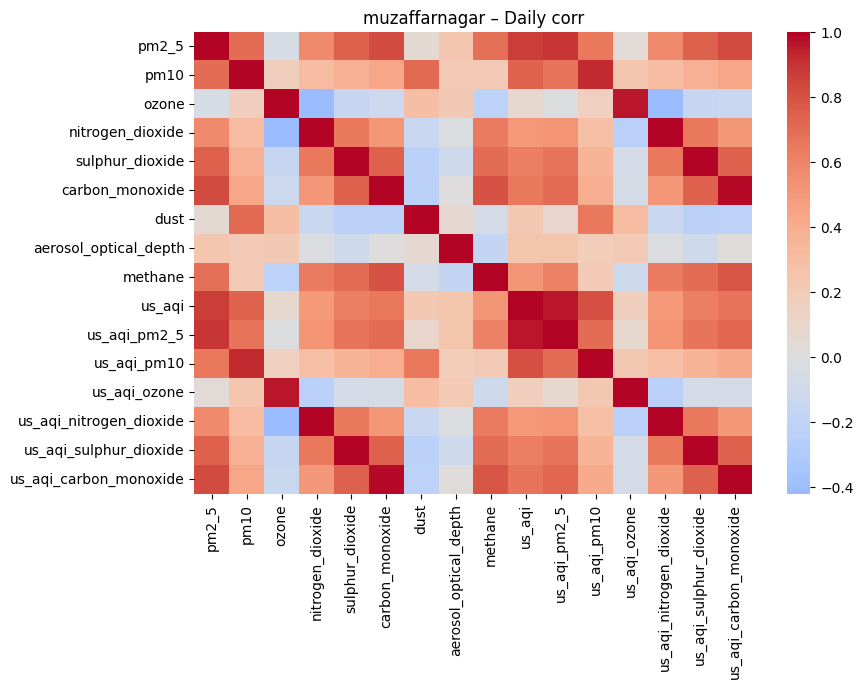

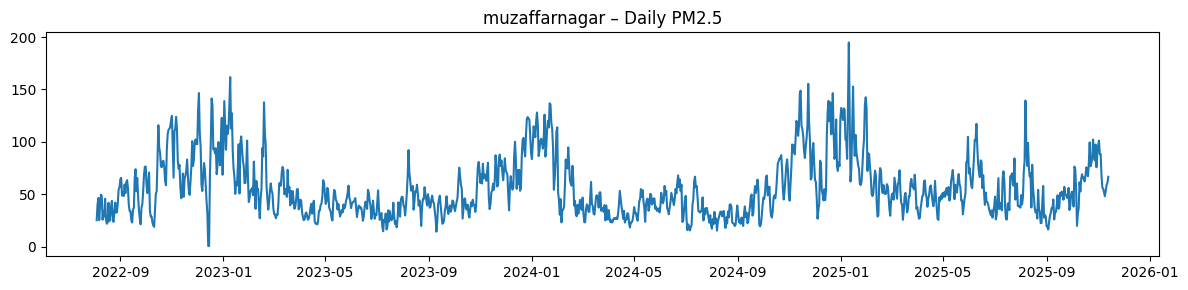

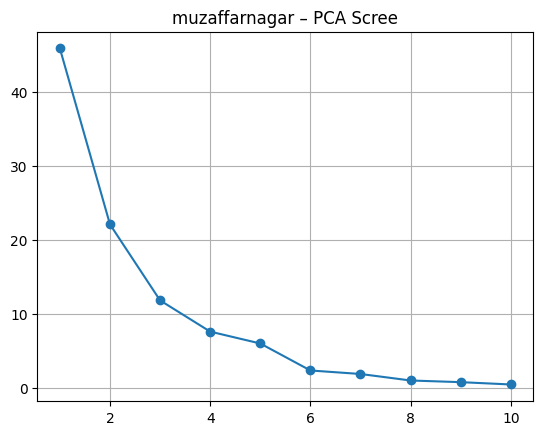

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
pm2_5,0.344599,0.049177,0.033053,0.067000,0.218917,0.015187,-0.207806,-0.208418,-0.231791,0.772170
us_aqi_pm2_5,0.327077,0.107145,0.024913,0.065689,0.240344,-0.137686,0.408325,0.162010,-0.592537,-0.253965
us_aqi_carbon_monoxide,0.321689,-0.137651,0.214166,-0.095517,0.073536,0.309643,-0.055927,-0.355149,0.056819,-0.345181
us_aqi_sulphur_dioxide,0.321373,-0.117170,0.215120,-0.080719,-0.051933,-0.417416,-0.249997,0.245796,0.154612,-0.075617
sulphur_dioxide,0.321152,-0.117138,0.215746,-0.082087,-0.052869,-0.419931,-0.248124,0.241228,0.154922,-0.077411
carbon_monoxide,0.320318,-0.140688,0.219386,-0.098704,0.041643,0.320344,-0.095683,-0.376657,0.067986,-0.195723
methane,0.305310,-0.129772,-0.036049,-0.051413,-0.219383,0.604191,0.089253,0.646630,0.079145,0.180254
us_aqi,0.301758,0.222977,-0.051380,0.008512,0.228322,-0.114624,0.504797,0.008489,0.151051,0.004411
nitrogen_dioxide,0.240633,-0.113080,-0.368494,0.327532,-0.377424,-0.093327,0.020004,-0.159052,-0.009637,-0.048414
us_aqi_nitrogen_dioxide,0.240540,-0.113099,-0.367633,0.327968,-0.378925,-0.093354,0.022071,-0.160474,-0.009451,-0.045046


muzaffarnagar – RF mean metrics: MAE=6.85, RMSE=9.11, R2=0.736


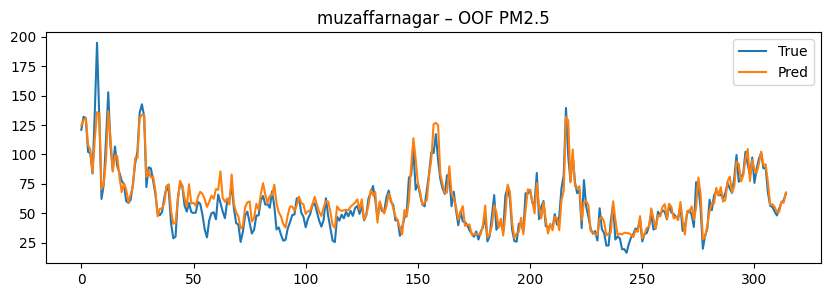

muzaffarnagar – KMeans Jaccard: intra=0.898, inter=0.427
muzaffarnagar – Agglomerative(Jaccard): intra=0.723, inter=0.000


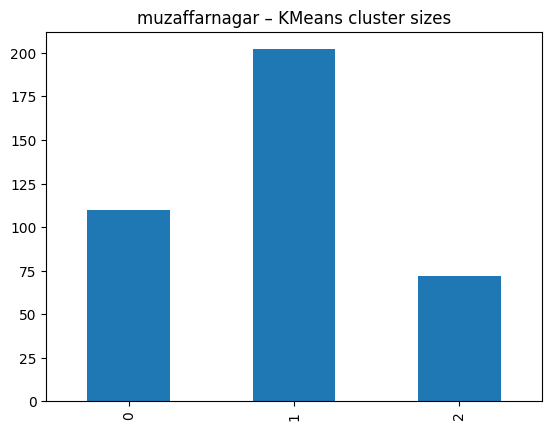

Saved muzaffarnagar_daily_air_quality.csv

Finished per-city processing.
['Udaipur', 'amritsar', 'faridabad', 'muzaffarnagar']


In [4]:
for city in cities:
    print("\n" + "="*80)
    print(f"Processing: {city}")
    print("="*80)
    hourly = fetch_hourly_for_city(city)
    if hourly.empty:
        print("No data fetched for", city)
        continue
    hourly.to_csv(f"{city.lower()}_hourly_air_quality.csv", index=False)
    print(f"Hourly rows: {len(hourly)} | Range: {hourly['time'].min()} -> {hourly['time'].max()}")

    # EDA
    num_cols = [c for c in hourly.columns if c not in ['time','city']]
    display(hourly[num_cols].isna().mean().sort_values(ascending=False).head(10))
    display(hourly[num_cols].describe().transpose().round(3))
    daily = hourly.set_index('time').resample('D').mean(numeric_only=True).reset_index()
    plt.figure(figsize=(9,6)); sns.heatmap(daily[num_cols].corr(), cmap='coolwarm', center=0); plt.title(f'{city} – Daily corr'); plt.show()
    if 'pm2_5' in daily.columns:
        plt.figure(figsize=(12,3)); plt.plot(daily['time'], daily['pm2_5']); plt.title(f'{city} – Daily PM2.5'); plt.tight_layout(); plt.show()

    # PCA
    pca_df = daily.dropna().copy()
    if len(pca_df) >= 10:
        X = pca_df.drop(columns=['time']).values
        Xz = StandardScaler().fit_transform(X)
        ncomp = min(10, Xz.shape[1])
        pca = PCA(n_components=ncomp).fit(Xz)
        expl = pca.explained_variance_ratio_*100
        plt.figure(); plt.plot(range(1,len(expl)+1), expl, marker='o'); plt.title(f'{city} – PCA Scree'); plt.grid(True); plt.show()
        loadings = pd.DataFrame(pca.components_.T, index=pca_df.drop(columns=['time']).columns, columns=[f'PC{i+1}' for i in range(ncomp)])
        display(loadings.sort_values('PC1', ascending=False).head(10))

    # Random Forest
    if 'pm2_5' in daily.columns:
        model_df = daily.copy()
        feats = [c for c in model_df.columns if c not in ['time','pm2_5']]
        for col in feats:
            for L in [1,2,3]:
                model_df[f"{col}_lag{L}"] = model_df[col].shift(L)
        model_df = model_df.dropna().reset_index(drop=True)
        if len(model_df) >= 100:
            y = model_df['pm2_5'].values
            X = model_df.drop(columns=['time','pm2_5']).values
            from sklearn.model_selection import TimeSeriesSplit
            tscv = TimeSeriesSplit(n_splits=5)
            maes=[]; rmses=[]; r2s=[]; y_true_all=[]; y_pred_all=[]
            for tr, te in tscv.split(X):
                rf = RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1)
                rf.fit(X[tr], y[tr])
                p = rf.predict(X[te])
                import math
                maes.append(mean_absolute_error(y[te], p))
                rmses.append(math.sqrt(mean_squared_error(y[te], p)))
                r2s.append(r2_score(y[te], p))
                y_true_all.append(y[te]); y_pred_all.append(p)
            print(f"{city} – RF mean metrics: MAE={np.mean(maes):.2f}, RMSE={np.mean(rmses):.2f}, R2={np.mean(r2s):.3f}")
            y_true_all = np.concatenate(y_true_all); y_pred_all = np.concatenate(y_pred_all)
            plt.figure(figsize=(10,3)); plt.plot(y_true_all, label='True'); plt.plot(y_pred_all, label='Pred'); plt.legend(); plt.title(f'{city} – OOF PM2.5'); plt.show()

    # Clustering with Jaccard
    thr = {'pm2_5':35.5,'pm10':55.0,'ozone':100.0,'nitrogen_dioxide':40.0,'sulphur_dioxide':75.0,'carbon_monoxide':4000.0}
    clu = daily.dropna().copy()
    bin_cols = [c for c in thr if c in clu.columns]
    if len(clu)>=20 and bin_cols:
        for c in bin_cols: clu[f"{c}_bad"] = (clu[c] >= thr[c]).astype(int)
        B = clu[[f"{c}_bad" for c in bin_cols]].fillna(0).astype(int).values
        K = 3
        km = KMeans(n_clusters=K, random_state=42, n_init=20)
        labels_km = km.fit_predict(B)
        intra, inter = cluster_jaccard_stats(B, labels_km)
        print(f"{city} – KMeans Jaccard: intra={intra:.3f}, inter={inter:.3f}")
        # Jaccard distance alternatives
        D = jaccard_distance_matrix(B)
        try:
            agg = AgglomerativeClustering(n_clusters=K, metric='precomputed', linkage='average')
            labels_agg = agg.fit_predict(D)
            intra2, inter2 = cluster_jaccard_stats(B, labels_agg)
            print(f"{city} – Agglomerative(Jaccard): intra={intra2:.3f}, inter={inter2:.3f}")
        except TypeError as e:
            print("Agglomerative metric not supported in this sklearn version:", e)
        if HAS_EXTRA:
            from sklearn_extra.cluster import KMedoids
            try:
                kmed = KMedoids(n_clusters=K, metric='precomputed', random_state=42)
                labels_kmed = kmed.fit_predict(D)
                intra3, inter3 = cluster_jaccard_stats(B, labels_kmed)
                print(f"{city} – KMedoids(Jaccard): intra={intra3:.3f}, inter={inter3:.3f}")
            except Exception as e:
                print("KMedoids failed:", e)
        plt.figure(); pd.Series(labels_km).value_counts().sort_index().plot(kind='bar'); plt.title(f'{city} – KMeans cluster sizes'); plt.show()
    else:
        print("Skipping clustering – insufficient daily rows or missing key pollutants.")

    daily.to_csv(f"{city.lower()}_daily_air_quality.csv", index=False)
    print(f"Saved {city.lower()}_daily_air_quality.csv")

print("\nFinished per-city processing.")

print(cities)

### Outputs
- One hourly CSV and one daily CSV **per city**
- All charts and metrics are printed in each city’s section above.


# LSTM Forecasting for PM2.5 (Next 72 Hours)

This section adds a recurrent LSTM model to **predict PM2.5 for the next 72 hours**.  
It is **self‑contained** and designed to be robust to common dataset layouts used earlier in the notebook.

> **What it expects from the earlier cells**
> - A pandas DataFrame already created somewhere above (commonly named `df`) that contains a PM2.5 column and a timestamp column.
> - Optional: a `city` column if the dataset is multi‑city.
>
> **How to use**
> 1. Run the configuration cell to pick your `TARGET_CITY` (if your data is multi‑city).
> 2. Run the remaining cells in order.  
> 3. Outputs:
>    - A plot comparing actual vs predicted values (on test split) and a 72h forecast.
>    - A CSV file `forecast_72h.csv` saved in the current working directory with timestamps and predicted PM2.5.
>
> **Dependencies**: `tensorflow` (or `tensorflow[and-cuda]` if you have GPU), `pandas`, `numpy`, `scikit-learn`, `matplotlib`.
> - Install (CPU): `pip install tensorflow pandas numpy scikit-learn matplotlib`
> - If you face TensorFlow install issues on Windows, try: `pip install tensorflow==2.15.1`

---


In [5]:
import pandas as pd
[name for name, obj in globals().items() if isinstance(obj, pd.DataFrame)]


['hourly', 'daily', 'pca_df', 'loadings', 'model_df', 'clu']

In [8]:
# ==================================================
# ✅ FIX: LOAD ALL CITY CSVs INTO A SINGLE DATAFRAME
# ==================================================

import pandas as pd
import glob

# Load all hourly_* CSV files generated earlier
csv_files = glob.glob("*_hourly_air_quality.csv")

if not csv_files:
    raise ValueError("❌ No per-city CSV files found. Run the fetch-data cell first.")

dfs = []
for f in csv_files:
    try:
        df_temp = pd.read_csv(f)
        dfs.append(df_temp)
        print(f"Loaded: {f} ({len(df_temp)} rows)")
    except Exception as e:
        print(f"⚠️ Could not load {f}: {e}")

# Concatenate all cities
df = pd.concat(dfs, ignore_index=True)

print("\n✔ Combined DataFrame created as 'df'")
print("Shape:", df.shape)
display(df.head())


Loaded: udaipur_hourly_air_quality.csv (28824 rows)
Loaded: muzaffarnagar_hourly_air_quality.csv (28824 rows)
Loaded: amritsar_hourly_air_quality.csv (28824 rows)
Loaded: faridabad_hourly_air_quality.csv (28824 rows)

✔ Combined DataFrame created as 'df'
Shape: (115296, 18)


,time,pm2_5,pm10,ozone,nitrogen_dioxide,sulphur_dioxide,carbon_monoxide,dust,aerosol_optical_depth,methane,us_aqi,us_aqi_pm2_5,us_aqi_pm10,us_aqi_ozone,us_aqi_nitrogen_dioxide,us_aqi_sulphur_dioxide,us_aqi_carbon_monoxide,city
0,2022-08-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Udaipur
1,2022-08-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Udaipur
2,2022-08-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Udaipur
3,2022-08-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Udaipur
4,2022-08-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Udaipur


In [6]:
# ============================================
# ✔ FIXED CONFIGURATION FOR MULTI-STEP LSTM
# ============================================

# Your DataFrame MUST be named "df"
DATAFRAME_NAME = "df"

# Choose a city (one of: "Amritsar", "Faridabad", "Udaipur")
# or set to None to use the whole dataset
TARGET_CITY = None   # e.g., "Udaipur", "Amritsar", "Faridabad"

# Column name candidates
TIMESTAMP_CANDIDATES = ["datetime", "timestamp", "date", "time", "DateTime", "Date", "Time", "Timestamp"]
PM25_CANDIDATES = ["pm2_5", "pm2.5", "PM2_5", "PM2.5", "PM25", "pm25", "pm_25", "PM_25"]

# Ensure hourly uniform frequency
RESAMPLE_FREQ = "1H"

# LSTM sequence settings
LOOKBACK = 72     # Use last 72 hours as input
HORIZON = 72      # Predict next 72 hours

# Training settings
EPOCHS = 20
BATCH_SIZE = 32
VAL_SPLIT = 0.15
RANDOM_STATE = 42

print("✔ Configuration Loaded Successfully\n")

# ============================================
# PREVIEW AVAILABLE CITIES (if df loaded)
# ============================================
_df_preview = globals().get(DATAFRAME_NAME, None)

if _df_preview is None:
    print(f"⚠️ DataFrame '{DATAFRAME_NAME}' not found yet. Load your data before running the next cell.")
else:
    if "city" in _df_preview.columns:
        city_list = sorted(list(map(str, _df_preview["city"].dropna().unique())))
        print("Available cities in your data:", city_list)
        print("\n➡️ Set TARGET_CITY to one of these above.")
    else:
        print("ℹ️ No 'city' column found. Proceeding without city filtering.")



✔ Configuration Loaded Successfully

⚠️ DataFrame 'df' not found yet. Load your data before running the next cell.



Processing: Amritsar


/tmp/ipython-input-1320487617.py:22: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end_date = datetime.utcnow().date().isoformat()
Fetching Amritsar:  97%|█████████▋| 1162/1200 [00:30<00:00, 38.09it/s]
/tmp/ipython-input-1320487617.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  out = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()


✔ Saved amritsar_hourly_air_quality.csv
Rows: 28824 | Range: 2022-08-01 00:00:00 → 2025-11-13 23:00:00


,0
methane,0.680440
us_aqi_pm10,0.003504
us_aqi,0.003504
us_aqi_pm2_5,0.003504
us_aqi_carbon_monoxide,0.002949
us_aqi_ozone,0.002949
us_aqi_nitrogen_dioxide,0.002741
pm2_5,0.002671
aerosol_optical_depth,0.002671
dust,0.002671


,count,mean,std,min,25%,50%,75%,max
pm2_5,28747.0,62.647,43.649,0.50,33.40,49.60,76.60,352.00
pm10,28747.0,95.264,67.278,0.70,51.60,76.40,118.30,873.60
ozone,28747.0,92.339,53.606,-3.00,49.00,82.00,134.00,300.00
nitrogen_dioxide,28747.0,21.852,23.543,-0.20,5.60,13.10,29.30,172.10
sulphur_dioxide,28747.0,12.750,8.275,0.00,7.10,10.60,16.00,76.40
carbon_monoxide,28747.0,764.654,659.928,59.00,349.00,539.00,918.00,7151.00
dust,28747.0,33.034,84.184,0.00,2.00,8.00,25.00,1444.00
aerosol_optical_depth,28747.0,0.592,0.352,0.03,0.34,0.52,0.76,3.73
methane,9211.0,1685.044,201.459,1381.00,1535.00,1636.00,1787.00,2722.00
us_aqi,28723.0,139.056,41.328,12.00,108.00,142.00,162.00,579.00


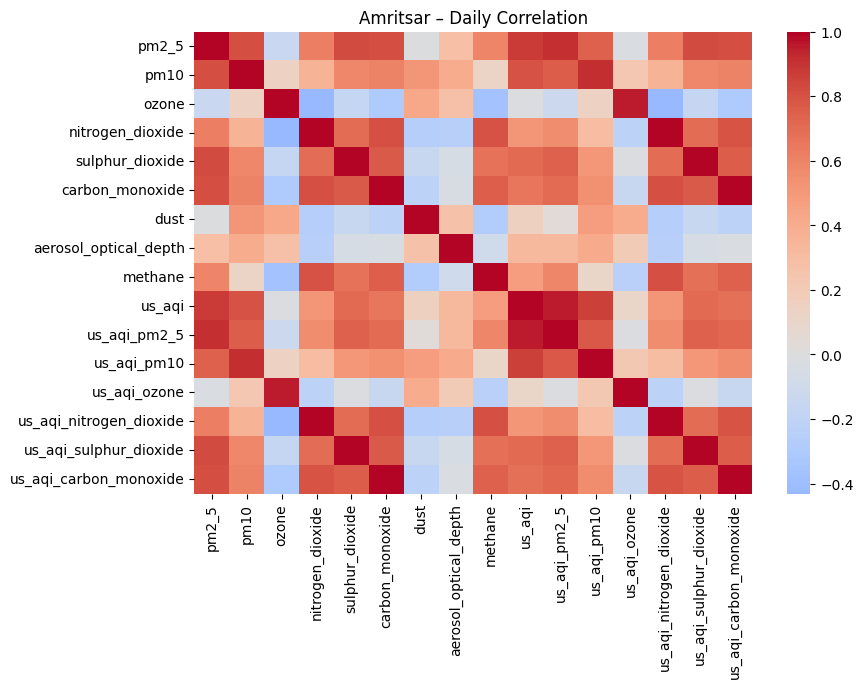

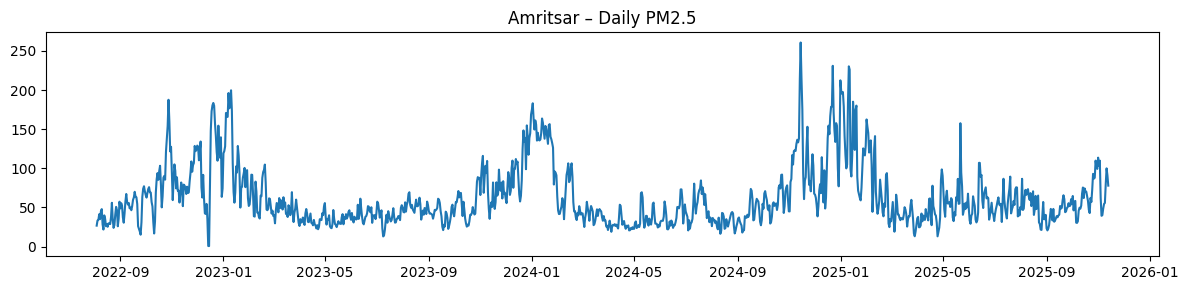


Processing: Faridabad


/tmp/ipython-input-1320487617.py:22: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end_date = datetime.utcnow().date().isoformat()
Fetching Faridabad:  97%|█████████▋| 1162/1200 [00:30<00:01, 37.77it/s]
/tmp/ipython-input-1320487617.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  out = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()


✔ Saved faridabad_hourly_air_quality.csv
Rows: 28824 | Range: 2022-08-01 00:00:00 → 2025-11-13 23:00:00


,0
methane,0.680440
us_aqi_pm10,0.003504
us_aqi,0.003504
us_aqi_pm2_5,0.003504
us_aqi_ozone,0.003122
us_aqi_carbon_monoxide,0.002949
pm2_5,0.002671
pm10,0.002671
aerosol_optical_depth,0.002671
dust,0.002671


,count,mean,std,min,25%,50%,75%,max
pm2_5,28747.0,78.097,51.811,0.30,41.70,64.30,99.70,443.30
pm10,28747.0,222.733,331.067,0.50,78.90,127.60,210.00,3263.40
ozone,28747.0,80.090,64.299,-11.00,29.00,63.00,128.00,322.00
nitrogen_dioxide,28747.0,48.527,41.123,0.00,17.60,35.80,69.20,336.00
sulphur_dioxide,28747.0,35.392,29.847,0.20,17.50,26.60,42.10,337.60
carbon_monoxide,28747.0,1029.900,1037.106,59.00,421.00,689.00,1248.00,14504.00
dust,28747.0,269.191,615.968,-4.00,8.00,42.00,187.00,5882.00
aerosol_optical_depth,28747.0,0.611,0.336,0.03,0.37,0.54,0.78,4.34
methane,9211.0,1586.451,142.463,1360.00,1489.00,1556.00,1648.00,2632.00
us_aqi,28723.0,222.834,264.643,12.00,129.00,158.00,186.00,2742.00


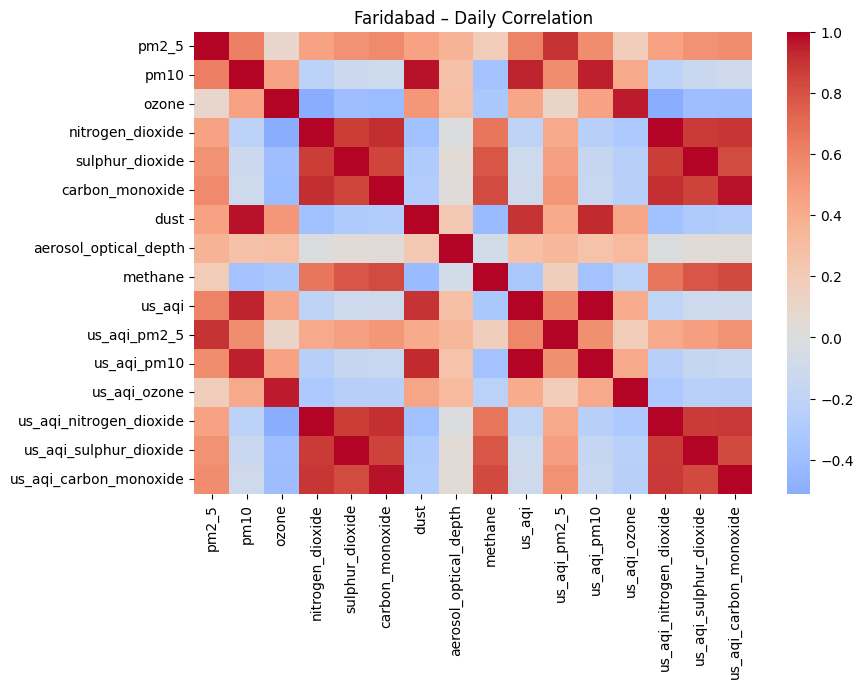

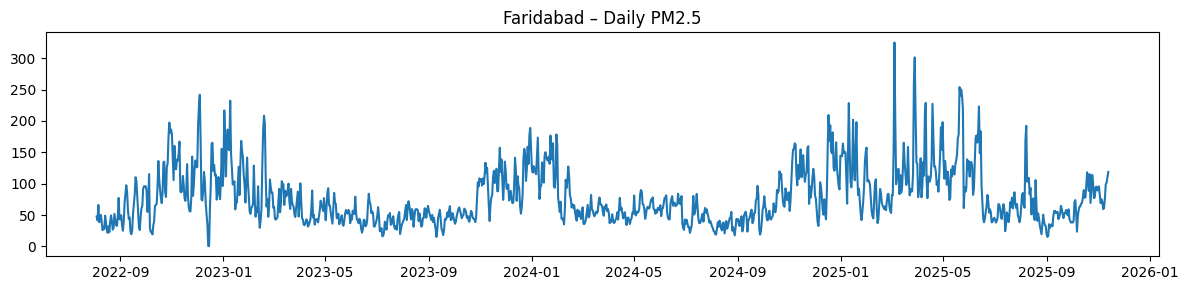


Processing: Muzaffarnagar


/tmp/ipython-input-1320487617.py:22: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end_date = datetime.utcnow().date().isoformat()
Fetching Muzaffarnagar:  97%|█████████▋| 1162/1200 [00:30<00:00, 38.67it/s]
/tmp/ipython-input-1320487617.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  out = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()


✔ Saved muzaffarnagar_hourly_air_quality.csv
Rows: 28824 | Range: 2022-08-01 00:00:00 → 2025-11-13 23:00:00


,0
methane,0.680440
us_aqi_pm10,0.003504
us_aqi,0.003504
us_aqi_pm2_5,0.003504
us_aqi_ozone,0.002984
us_aqi_carbon_monoxide,0.002949
us_aqi_nitrogen_dioxide,0.002741
pm2_5,0.002671
aerosol_optical_depth,0.002671
dust,0.002671


,count,mean,std,min,25%,50%,75%,max
pm2_5,28747.0,55.973,32.568,0.00,32.80,47.40,70.80,265.40
pm10,28747.0,93.609,65.258,0.00,52.00,78.20,117.10,990.90
ozone,28747.0,91.762,47.520,-3.00,55.00,83.00,128.00,256.00
nitrogen_dioxide,28747.0,16.842,15.330,-1.00,6.10,12.60,22.00,115.10
sulphur_dioxide,28747.0,14.374,8.690,0.20,8.50,12.10,18.00,101.70
carbon_monoxide,28747.0,566.618,358.372,59.00,321.00,451.00,698.00,3295.00
dust,28747.0,48.870,106.638,0.00,2.00,9.00,40.00,1590.00
aerosol_optical_depth,28747.0,0.559,0.309,0.03,0.33,0.49,0.71,3.04
methane,9211.0,1615.603,138.784,1392.00,1514.00,1582.00,1688.00,2276.00
us_aqi,28723.0,132.514,36.809,13.00,102.00,137.00,159.00,459.00


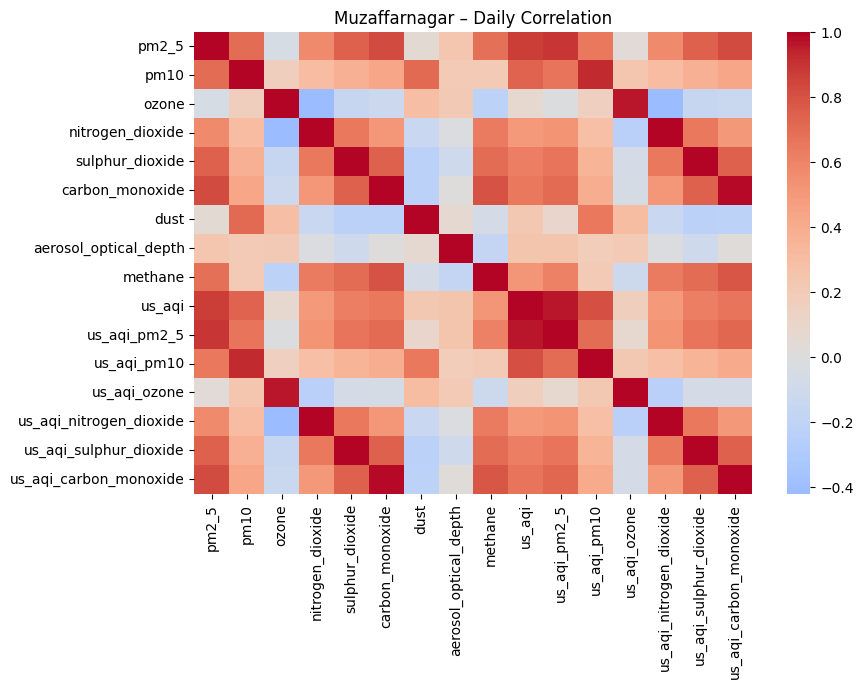

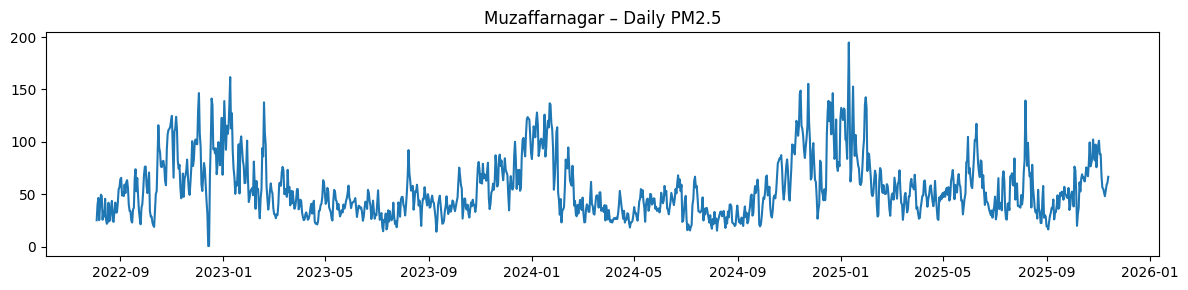


Processing: Udaipur


/tmp/ipython-input-1320487617.py:22: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end_date = datetime.utcnow().date().isoformat()
Fetching Udaipur:  97%|█████████▋| 1162/1200 [00:28<00:00, 40.61it/s]
/tmp/ipython-input-1320487617.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  out = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()


✔ Saved udaipur_hourly_air_quality.csv
Rows: 28824 | Range: 2022-08-01 00:00:00 → 2025-11-13 23:00:00


,0
methane,0.680440
us_aqi_pm10,0.003504
us_aqi,0.003504
us_aqi_pm2_5,0.003504
us_aqi_carbon_monoxide,0.002949
us_aqi_ozone,0.002949
pm2_5,0.002671
pm10,0.002671
aerosol_optical_depth,0.002671
dust,0.002671


,count,mean,std,min,25%,50%,75%,max
pm2_5,28747.0,21.629,13.362,0.20,12.70,18.30,27.10,129.90
pm10,28747.0,37.111,22.128,0.20,22.10,32.80,47.50,356.70
ozone,28747.0,83.505,30.952,5.00,60.00,78.00,105.00,178.00
nitrogen_dioxide,28747.0,6.907,6.770,0.00,2.10,5.20,9.30,56.90
sulphur_dioxide,28747.0,6.221,4.336,0.20,3.20,5.00,7.90,35.40
carbon_monoxide,28747.0,239.753,103.786,58.00,160.00,213.00,298.00,876.00
dust,28747.0,20.400,32.833,0.00,2.00,8.00,25.00,558.00
aerosol_optical_depth,28747.0,0.332,0.199,0.02,0.19,0.29,0.43,2.17
methane,9211.0,1419.208,57.956,1314.00,1373.00,1404.00,1457.00,1685.00
us_aqi,28723.0,72.533,26.956,14.00,55.00,66.00,86.00,179.00


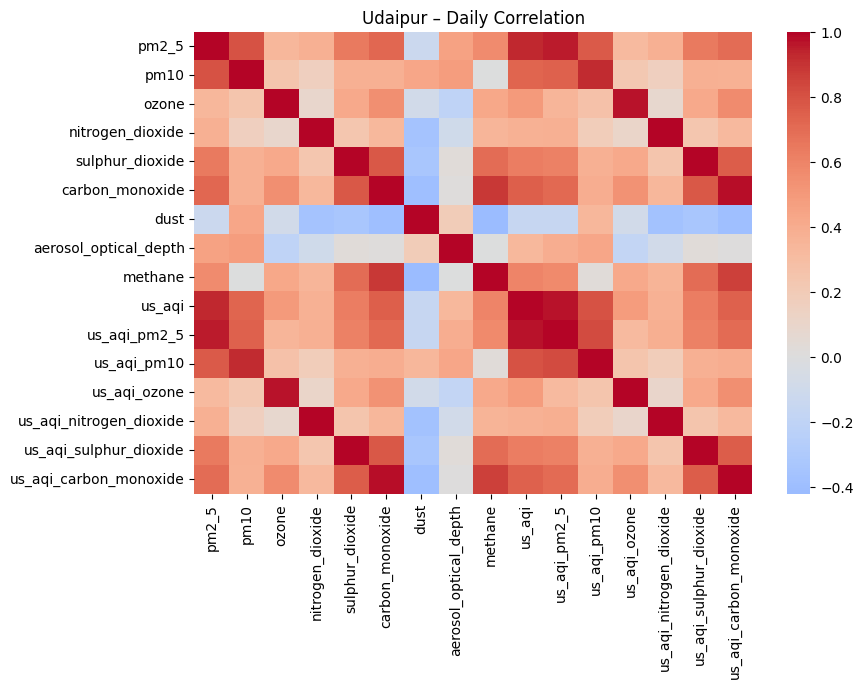

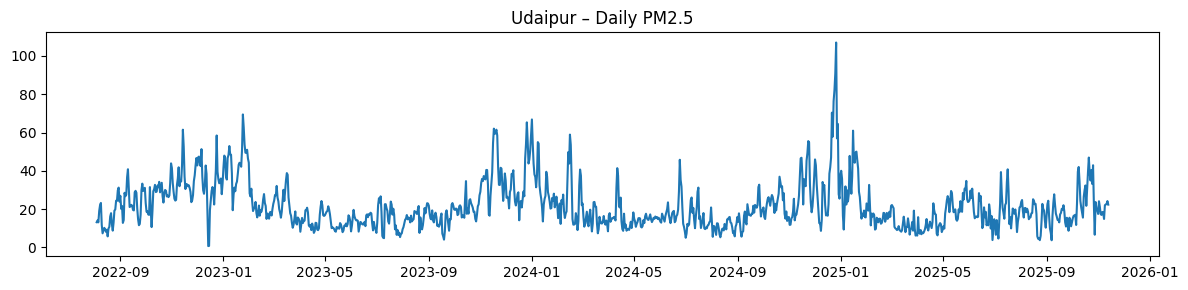


Finished per-city processing.


In [19]:
# ============================================================
# ✔ FIXED BLOCK — ADDS CITY COLUMN BEFORE SAVING CSV
# ============================================================

for city in cities:
    print("\n" + "="*80)
    print(f"Processing: {city}")
    print("="*80)

    # Fetch data
    hourly = fetch_hourly_for_city(city)

    if hourly.empty:
        print(f"❌ No data fetched for {city}, skipping.")
        continue

    # ⭐ IMPORTANT FIX — Add city name inside the dataframe
    hourly["city"] = city

    # Save per-city CSV
    hourly.to_csv(f"{city.lower()}_hourly_air_quality.csv", index=False)
    print(f"✔ Saved {city.lower()}_hourly_air_quality.csv")
    print(f"Rows: {len(hourly)} | Range: {hourly['time'].min()} → {hourly['time'].max()}")

    # -------- EDA PLOTS ----------
    num_cols = [c for c in hourly.columns if c not in ['time', 'city']]

    # Missing values
    display(hourly[num_cols].isna().mean().sort_values(ascending=False).head(10))

    # Stats summary
    display(hourly[num_cols].describe().transpose().round(3))

    # Daily resample
    daily = hourly.set_index('time').resample('D').mean(numeric_only=True).reset_index()

    # Correlation heatmap
    plt.figure(figsize=(9,6))
    sns.heatmap(daily[num_cols].corr(), cmap='coolwarm', center=0)
    plt.title(f'{city} – Daily Correlation')
    plt.show()

    # Daily PM2.5
    if 'pm2_5' in daily.columns:
        plt.figure(figsize=(12,3))
        plt.plot(daily['time'], daily['pm2_5'])
        plt.title(f'{city} – Daily PM2.5')
        plt.tight_layout()
        plt.show()

print("\nFinished per-city processing.")


In [20]:
# ============================================
# ✔ FIXED PM2.5 SERIES PREPARATION CELL
# ============================================

import numpy as np
import pandas as pd

# --------------------------------------------
# Load DataFrame
# --------------------------------------------
df_main = globals().get(DATAFRAME_NAME, None)

if df_main is None or not hasattr(df_main, "columns"):
    raise ValueError(f"❌ DataFrame named '{DATAFRAME_NAME}' not found. Load data first or update DATAFRAME_NAME.")

work = df_main.copy()

# --------------------------------------------
# Optional City Filter
# --------------------------------------------
if TARGET_CITY is not None:
    if "city" not in work.columns:
        raise ValueError("❌ TARGET_CITY is set but no 'city' column exists in DataFrame.")

    work = work[work["city"].astype(str).str.lower() == str(TARGET_CITY).lower()]
    if work.empty:
        raise ValueError(f"❌ No rows found for TARGET_CITY='{TARGET_CITY}'. Check spelling.")

    print(f"➡️ Filtering for city: {TARGET_CITY}")

# --------------------------------------------
# Find timestamp column
# --------------------------------------------
ts_col = None
for c in TIMESTAMP_CANDIDATES:
    if c in work.columns:
        ts_col = c
        break

# If missing, check index
if ts_col is None:
    if isinstance(work.index, pd.DatetimeIndex):
        work = work.reset_index().rename(columns={"index": "datetime"})
        ts_col = "datetime"
    else:
        raise ValueError(f"❌ No timestamp column found. Expected one of {TIMESTAMP_CANDIDATES}")

print(f"➡️ Timestamp column detected: {ts_col}")

# --------------------------------------------
# Find PM2.5 column
# --------------------------------------------
y_col = None

# Exact matches
for c in PM25_CANDIDATES:
    if c in work.columns:
        y_col = c
        break

# Heuristic fallback
if y_col is None:
    for c in work.columns:
        if "pm2" in c.lower().replace(" ", ""):
            y_col = c
            break

if y_col is None:
    raise ValueError(f"❌ No PM2.5 column found. Expected names like {PM25_CANDIDATES}")

print(f"➡️ PM2.5 column detected: {y_col}")

# --------------------------------------------
# Clean + Prepare Time Series
# --------------------------------------------
work = work[[ts_col, y_col]].dropna().copy()
work[ts_col] = pd.to_datetime(work[ts_col], errors="coerce")
work = work.dropna(subset=[ts_col]).sort_values(ts_col).set_index(ts_col)

# Resample to hourly and fill missing values
work = work.resample(RESAMPLE_FREQ).mean()
work[y_col] = work[y_col].interpolate(method="time").bfill().ffill()

# --------------------------------------------
# Final Series
# --------------------------------------------
print("\n📌 Cleaned PM2.5 series preview:")
display(work.head())
display(work.tail())

series = work[y_col].astype("float32").to_frame(name=y_col)
print(f"\n✔ Final series ready for multi-step LSTM. Using: '{y_col}'")


➡️ Timestamp column detected: time
➡️ PM2.5 column detected: pm2_5

📌 Cleaned PM2.5 series preview:


/tmp/ipython-input-2197848676.py:81: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  work = work.resample(RESAMPLE_FREQ).mean()


,pm2_5
time,
2022-08-04 05:00:00,27.1
2022-08-04 06:00:00,24.8
2022-08-04 07:00:00,23.6
2022-08-04 08:00:00,23.3
2022-08-04 09:00:00,24.4


,pm2_5
time,
2025-11-13 19:00:00,53.3
2025-11-13 20:00:00,60.3
2025-11-13 21:00:00,67.3
2025-11-13 22:00:00,75.0
2025-11-13 23:00:00,82.0



✔ Final series ready for multi-step LSTM. Using: 'pm2_5'


In [21]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Ensure 'series' (pd.Series) exists in the notebook namespace
try:
    series  # noqa: F821
except NameError:
    raise NameError("Required variable 'series' not found. Run the earlier cells that prepare the PM2.5 series first.")

# Prepare values (ensure shape is (N, 1))
values = series.values.reshape(-1, 1)  # (N, 1)
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)

def make_sequences(arr, lookback=72):
    """
    Create supervised sequences for LSTM:
      - arr: numpy array of shape (N, 1)
      - lookback: number of timesteps used as input
    Returns X shaped (samples, lookback, 1) and y shaped (samples,)
    """
    if arr.ndim == 1:
        arr = arr.reshape(-1, 1)
    X, y = [], []
    for i in range(lookback, len(arr)):
        X.append(arr[i - lookback:i, 0])
        y.append(arr[i, 0])
    X = np.array(X)
    y = np.array(y)
    # reshape to [samples, timesteps, features]
    if X.size == 0:
        return X.reshape((0, lookback, 1)), y
    X = X.reshape((X.shape[0], X.shape[1], 1))
    return X, y

# Validate we have enough data
if len(scaled) <= 72:
    print("Warning: scaled series length is small (<=72). LSTM may not train well.")

# Train/test split (80/20 by time)
split_idx = int(0.8 * len(scaled))
train_arr, test_arr = scaled[:split_idx], scaled[split_idx:]

# Build sequences from contiguous windows
X_train, y_train = make_sequences(train_arr, lookback=LOOKBACK)

# For test sequences, build from the full scaled array and select windows whose target index >= split_idx
X_full, y_full = make_sequences(scaled, lookback=LOOKBACK)
# y_full corresponds to original indices LOOKBACK .. len(scaled)-1
orig_indices = np.arange(LOOKBACK, len(scaled))
mask = orig_indices >= split_idx
X_test = X_full[mask]
y_test = y_full[mask]

print(f"Train sequences: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Test sequences:  X_test={X_test.shape}, y_test={y_test.shape}")

Train sequences: X_train=(22925, 72, 1), y_train=(22925,)
Test sequences:  X_test=(5750, 72, 1), y_test=(5750,)


In [18]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

tf.keras.utils.set_random_seed(RANDOM_STATE)

model = Sequential([
    LSTM(64, input_shape=(LOOKBACK, 1), return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")
history = model.fit(
    X_train, y_train,
    validation_split=VAL_SPLIT,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

print("Training complete.")


Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


609/609 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0034 - val_loss: 0.0040
Epoch 2/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 7.4310e-04 - val_loss: 0.0013
Epoch 3/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 4.0243e-04 - val_loss: 0.0011
Epoch 4/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 3.1111e-04 - val_loss: 9.6284e-04
Epoch 5/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 2.8891e-04 - val_loss: 9.4283e-04
Epoch 6/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 2.8038e-04 - val_loss: 9.1976e-04
Epoch 7/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 2.6175e-04 - val_loss: 9.1178e-04
Epoch 8/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 2.6627e-04 - val_loss: 8.9494e-04
Epoch 9/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 2.6000e-04 - val_loss: 8.7728e-04
Epoch 10/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 2.5009e-04 - val_loss: 8.6037e-04
Epoch 11/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 2.5010e-04 - val_lo

In [22]:

# Evaluate on test
y_pred_test_scaled = model.predict(X_test)
# inverse scale
y_pred_test = scaler.inverse_transform(y_pred_test_scaled)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

mae = mean_absolute_error(y_test_inv, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_test))  # manual RMSE
print(f"Test MAE: {mae:.3f}, RMSE: {rmse:.3f}")

# Build aligned index for test predictions
# y_full corresponds to original indices LOOKBACK..end
idx_all = series.index
test_idx = idx_all[LOOKBACK + (len(y_full) - len(y_test_inv)) : LOOKBACK + len(y_full)]
# Alternative simpler alignment:
test_idx = idx_all[-len(y_test_inv):]

pred_df = pd.DataFrame({
    "timestamp": test_idx,
    "actual_pm25": y_test_inv.flatten(),
    "pred_pm25": y_pred_test.flatten()
}).set_index("timestamp")

display(pred_df.tail())


180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test MAE: 3.792, RMSE: 5.931


,actual_pm25,pred_pm25
timestamp,,
2025-11-13 19:00:00,53.299999,59.853451
2025-11-13 20:00:00,60.299999,64.498787
2025-11-13 21:00:00,67.300003,67.660034
2025-11-13 22:00:00,75.000000,72.137619
2025-11-13 23:00:00,82.000000,78.373619


In [23]:

# Recursive 72-hour forecast starting from the last LOOKBACK window
last_window = scaled[-LOOKBACK:].copy().reshape(1, LOOKBACK, 1)
future_scaled = []
for _ in range(HORIZON):
    next_scaled = model.predict(last_window, verbose=0)[0, 0]
    future_scaled.append(next_scaled)
    # slide the window
    last_window = np.concatenate([last_window[:, 1:, :], np.array(next_scaled).reshape(1, 1, 1)], axis=1)

future_scaled = np.array(future_scaled).reshape(-1, 1)
future_inv = scaler.inverse_transform(future_scaled).flatten()

# Future timestamps
last_ts = series.index[-1]
future_index = pd.date_range(last_ts + pd.Timedelta(hours=1), periods=HORIZON, freq="H")

forecast_df = pd.DataFrame({"pm25_forecast": future_inv}, index=future_index)
forecast_df.index.name = "timestamp"

# Save forecast to CSV
forecast_df.to_csv("forecast_72h.csv")
print("Saved 72h forecast to 'forecast_72h.csv'")
display(forecast_df.head())
display(forecast_df.tail())


Saved 72h forecast to 'forecast_72h.csv'


/tmp/ipython-input-752778366.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_index = pd.date_range(last_ts + pd.Timedelta(hours=1), periods=HORIZON, freq="H")


,pm25_forecast
timestamp,
2025-11-14 00:00:00,84.053619
2025-11-14 01:00:00,83.675644
2025-11-14 02:00:00,82.359497
2025-11-14 03:00:00,81.204430
2025-11-14 04:00:00,80.615952


,pm25_forecast
timestamp,
2025-11-16 19:00:00,79.116051
2025-11-16 20:00:00,84.700340
2025-11-16 21:00:00,88.830460
2025-11-16 22:00:00,91.028610
2025-11-16 23:00:00,91.180885


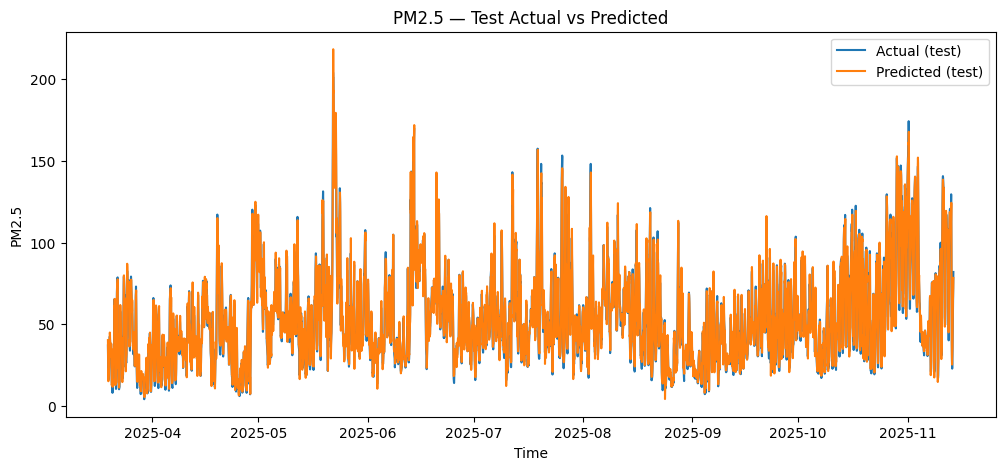

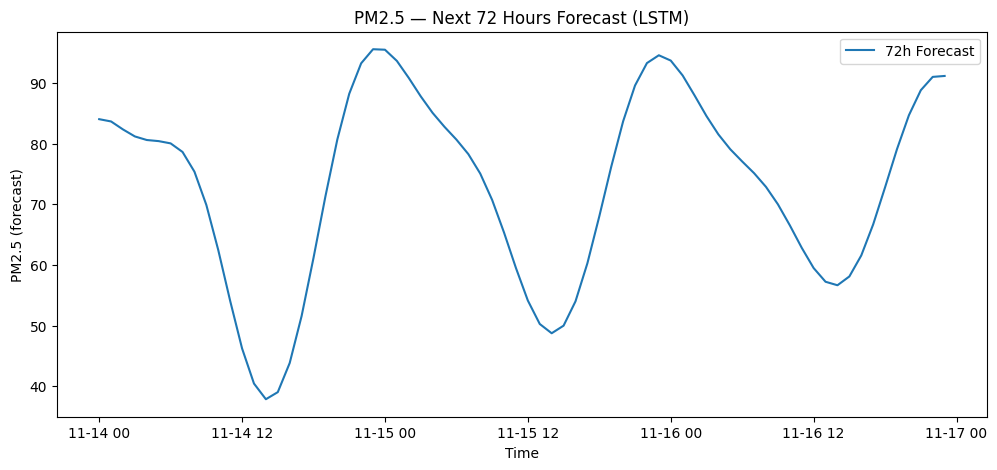

In [24]:

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(series.index[-len(pred_df):], pred_df["actual_pm25"], label="Actual (test)")
plt.plot(series.index[-len(pred_df):], pred_df["pred_pm25"], label="Predicted (test)")
plt.legend()
plt.title("PM2.5 — Test Actual vs Predicted")
plt.xlabel("Time"); plt.ylabel("PM2.5")
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(forecast_df.index, forecast_df["pm25_forecast"], label="72h Forecast")
plt.legend()
plt.title("PM2.5 — Next 72 Hours Forecast (LSTM)")
plt.xlabel("Time"); plt.ylabel("PM2.5 (forecast)")
plt.show()
